The two datasets used in this analysis can be found here.

FIDE Expected score - https://chess.stackexchange.com/questions/19653/how-to-calculate-the-fide-percentage-expectancy-table <br>
ChessDB dataset - https://www.kaggle.com/milesh1/35-million-chess-games <br>
ChessDB documentation - https://chess-research-project.readthedocs.io/en/latest/

FIDE, the governing body of chess, has released a table that calculates expected score based on opponent's rating as given by both players ELO score. I set out to calculate if this table is accurate. I also seek to answer questions of how much the colors white and black factor into this, as these tend to have a larger effect at the highest level. I will also see if this holds above certain rating levels, as ratings potentially break down at the greatest extremes.


In [28]:
import pandas as pd
import numpy as np
import os
import urllib.request
import zipfile

if not(os.path.exists('all_with_filtered_anotations_since1998.txt')):
    url = 'https://www.kaggle.com/milesh1/35-million-chess-games/download'

    urllib.request.urlretrieve(url, '35-million-chess-games.zip')
    with zipfile.ZipFile('35-million-chess-games.zip', 'r') as zip_ref:
        zip_ref.extractall('os.getcwd()')
chessdb = pd.read_csv('all_with_filtered_anotations_since1998.txt', sep = ' ', header = None, names = ['Index', 'Date', 'Result', 'wELO', 'bELO', 'len', 'dateX', 'resuX', 'wELOX', 'bELOX', 'edateX', 'setX', 'fenX', 'resu2', 'yrange', 'lenX', 'game'], index_col = 0, skiprows = [0,1,2,3,4], usecols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])


BadZipFile: File is not a zip file

In [2]:
print(chessdb.head(10))

             Date   Result  wELO  bELO  len       dateX         resuX  \
Index                                                                   
1      2000.03.14      1-0  2851  None   67  date_false  result_false   
2      2000.03.14      1-0  2851  None   53  date_false  result_false   
3      1999.11.20      1-0  2851  None   57  date_false  result_false   
4      1999.11.20      1-0  2851  None   49  date_false  result_false   
5      2000.02.20  1/2-1/2  2851  2633   97  date_false  result_false   
6      2000.05.24  1/2-1/2  2851  2748   52  date_false  result_false   
7      2000.06.19      1-0  2851  2191   79  date_false  result_false   
8      1999.11.20      1-0  2851  None   71  date_false  result_false   
9      2000.06.19  1/2-1/2  2851  2175   72  date_false  result_false   
10     2000.01.18      1-0  2851  2646   49  date_false  result_false   

            wELOX       bELOX       edateX         setX       fenX  \
Index                                                

In [3]:
df = chessdb.copy()
df = pd.DataFrame(df)
len(df.columns)

16

In [4]:
##Removing games where white or black ELO is missing
#Removing games with Result issues
#Removing games with setup issues
df = df[(df['wELO'] != 'None') & (df['bELO'] != 'None')]
df = df[df['resuX'] == 'result_false']
df = df[df['setX'] == 'setup_false']

In [5]:
##dropping unnecessary or used columns
df = df.drop(['wELOX', 'bELOX', 'yrange', 'game', 'fenX', 'resu2', 'edateX', 'resuX', 'setX'], axis = 1)


In [6]:
##Checking the counts of the results to make sure the results are sensible. I expect to see more white wins than black wins
##as white has a significant advantage over black at the highest level of chess.
df.groupby('Result').count()

,Date,wELO,bELO,len,dateX,lenX
Result,,,,,,
0-1,558832,558832,558832,558832,558832,558832
1-0,719018,719018,719018,719018,719018,719018
1/2-1/2,674928,674928,674928,674928,674928,674928


In [7]:
##Calculating the ELO difference from white and black POV
df['wELOdiff'] = df['wELO'].astype(np.int64) - df['bELO'].astype(np.int64)
df['bELOdiff'] = df['bELO'].astype(np.int64) - df['wELO'].astype(np.int64)

##Converting Results to floats and cleaning results.
df['Result'] = df['Result'].replace({'1/2-1/2': 0.5, '1-0': 1, '0-1': 0})
df['Result'] = df.loc[df['Result'] != '*', 'Result']
df = df.dropna()
df['Result'] = df['Result'].astype(float)


##For now we are leaving in false lengths and false dates, as these should not affect a score based analysis.
##We will remove this when we are analyzing by date or by game length.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [8]:
##Sanity check that cleaning results did not alter results greatly.
df.groupby('Result').count()

,Date,wELO,bELO,len,dateX,lenX,wELOdiff,bELOdiff
Result,,,,,,,,
0.0,558832,558832,558832,558832,558832,558832,558832,558832
0.5,674928,674928,674928,674928,674928,674928,674928,674928
1.0,719018,719018,719018,719018,719018,719018,719018,719018


In [9]:
##Add 800 ELO Cutoffs to match expected score table
df = df.loc[df['wELOdiff'] <= 800]
df = df.loc[df['wELOdiff'] >= -800]

In [10]:
##Group by ELO diff to prepare for visualization
groupdf = df.groupby('wELOdiff')
groupdfmeans = groupdf.mean()
groupedmeans = df.groupby('wELOdiff')['Result'].mean()

groupblack = df.groupby('bELOdiff')
groupblackmeans = groupblack.mean()
groupedblackmeans = df.groupby('bELOdiff')['Result'].mean()

pd
print(groupdf['Result'].count())

wELOdiff
-800    17
-799    11
-798     6
-797     8
-796     6
        ..
 796     7
 797     5
 798     7
 799     8
 800    14
Name: Result, Length: 1601, dtype: int64


<IPython.core.display.Javascript object>


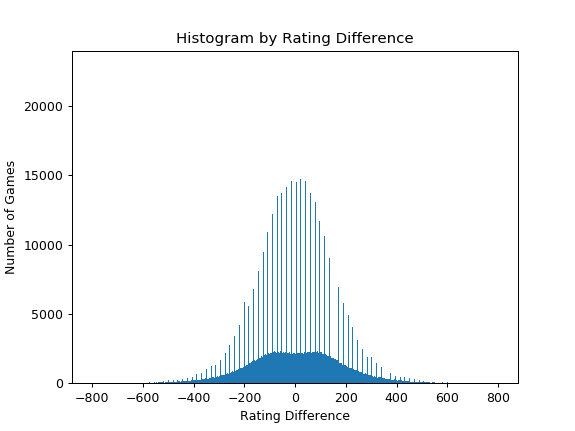

Text(0.5, 1.0, 'Histogram by Rating Difference')

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['wELOdiff'], 1600);
plt.xlabel('Rating Difference')
plt.ylabel('Number of Games')
plt.title('Histogram by Rating Difference')

This histogram of the ELO differences shows that there is some inherent bias in the data: It appears that certain ELO differences are reported with greater frequency than others. This is likely due to rounding, but it is also possible that certain data entries are faulty. We also see that the tails often have very tiny sample sizes, which could be aided using larger bins.

In [12]:
##Prepare Expected score table

score = np.arange(0, 1.01, .01)
score
##RD as described by FIDE Rating Regulation 8.1a. Arbitrary caps at -800 and 800.
RD = [-800, -677, -589, -538, -501, -470, -444, -422, -401, -383, -366, -351, -336, -322, -309, -296, -284, -273, -262, -251, -240, -230, -220, -211, -202, -193, -184, -175, -166, -158, -149, -141, -133, -125, -117, -110, -102, -95, -87, -80, -72, -65, -57, -50, -43, -36, -29, -21, -14, -7, 0]
RDPos = [abs(item) for item in RD]
RDPos.reverse()
del RDPos[0]
for item in RDPos:
    RD.append(item)
print(RD)
ratingdf = pd.DataFrame({'RD': RD, 'Score': score})

[-800, -677, -589, -538, -501, -470, -444, -422, -401, -383, -366, -351, -336, -322, -309, -296, -284, -273, -262, -251, -240, -230, -220, -211, -202, -193, -184, -175, -166, -158, -149, -141, -133, -125, -117, -110, -102, -95, -87, -80, -72, -65, -57, -50, -43, -36, -29, -21, -14, -7, 0, 7, 14, 21, 29, 36, 43, 50, 57, 65, 72, 80, 87, 95, 102, 110, 117, 125, 133, 141, 149, 158, 166, 175, 184, 193, 202, 211, 220, 230, 240, 251, 262, 273, 284, 296, 309, 322, 336, 351, 366, 383, 401, 422, 444, 470, 501, 538, 589, 677, 800]


<IPython.core.display.Javascript object>


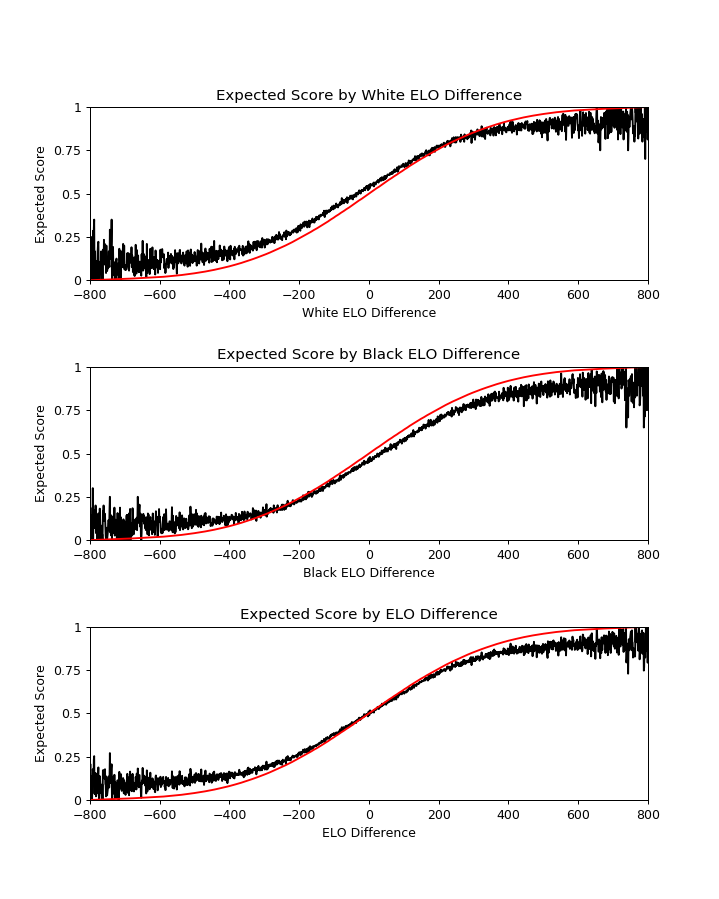

Text(0, 0.5, 'Expected Score')

In [13]:
##Plotting white score vs expected score
f, ax = plt.subplots(3, 1, figsize = (8,10))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(311)
ax1 = f.gca()
ax1.plot(groupdfmeans.index.get_level_values(0), groupedmeans, 'black', '-', label = 'ChessDB Data')
ax1.plot(RD, score, 'r', '-', label = 'FIDE Expected Score')
ax1.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by White ELO Difference')
plt.xlabel('White ELO Difference')
plt.ylabel('Expected Score')

##Plotting black score vs expected score
plt.subplot(3,1,2)
ax2 = f.gca()
ax2.plot(groupblackmeans.index.get_level_values(0), 1 - groupblackmeans['Result'], 'black', '-')
ax2.plot(RD, score, 'r', '-')
ax2.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by Black ELO Difference')
plt.xlabel('Black ELO Difference')
plt.ylabel('Expected Score')

##Plotting average score vs expected score
plt.subplot(3,1,3)
ax3 = f.gca()
ax3.plot(groupblackmeans.index.get_level_values(0), (1 - groupblackmeans['Result'] + groupedmeans)/2, 'black', '-')
ax3.plot(RD, score, 'r', '-')
ax3.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by ELO Difference')
plt.xlabel('ELO Difference')
plt.ylabel('Expected Score')

Some comments on the above graphs. It is important to note an inherent bias in the dataset. This is a collection of master games, and as such, these results do not generalize well to ALL chess players, only to chess players whose games are likely to end up in a master database. It appears that the FIDE Expected score approximates the data well when the players are close in ELO, but as we approach extreme ELO differences the FIDE Expected score makes a very poor approximation. This is actually not surprising given the first caveat: at the highest level of play draws become much more prevalent, which is a possible explanation for the deviation in expected score. A final thought is that the graphs become highly variable at the endpoints as sample sizes become low, I include the next graph where I bin the ELO Differences by groups of 10 in order to smooth out this variation towards the extremes.

In [14]:
##Generating binned ELO Diffs
df['wELOdiff10'] = df['wELOdiff']/10
df['wELOdiff10'] = df['wELOdiff10'].apply(round)
df['wELOdiff10'] = df['wELOdiff10']*10

df['bELOdiff10'] = df['bELOdiff']/10
df['bELOdiff10'] = df['bELOdiff10'].apply(round)
df['bELOdiff10'] = df['bELOdiff10']*10

In [15]:
##Set up groups for graphing
groupbin = df.groupby('wELOdiff10')
groupbinmeans = groupbin.mean()
groupedbinmeans = df.groupby('wELOdiff10')['Result'].mean()

gbblackbin = df.groupby('bELOdiff10')
gbblackbinmeans = gbblackbin.mean()

<IPython.core.display.Javascript object>


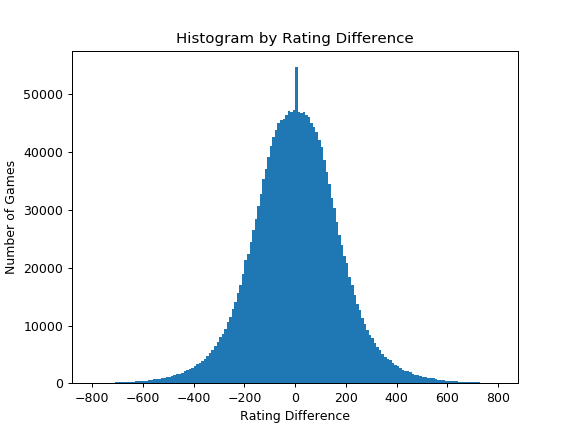

Text(0.5, 1.0, 'Histogram by Rating Difference')

In [16]:
plt.figure()
plt.hist(df['wELOdiff'], 160);
plt.xlabel('Rating Difference')
plt.ylabel('Number of Games')
plt.title('Histogram by Rating Difference')

Here is a histogram of the ELO Differences but this time grouped in bins of width 10 much like the data. The bias visisble in the previous histogram is much less visisble, but still apparent in the huge spike at 0, showing that there is either rounding or poor data present in the dataset.

<IPython.core.display.Javascript object>


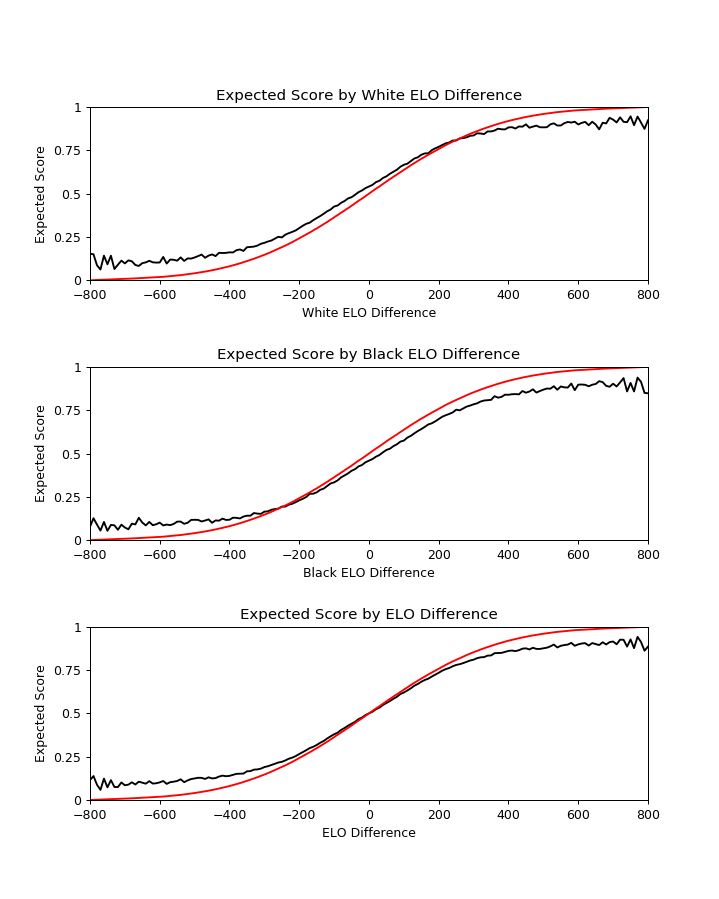

In [17]:
##Making graphs based on Grouped ELO Differences.
f, ax = plt.subplots(3, 1, figsize = (8,10))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(311)
ax1 = f.gca()
ax1.plot(groupbinmeans.index.get_level_values(0), groupbinmeans['Result'], 'black', '-', label = 'ChessDB Data')
ax1.plot(RD, score, 'r', '-', label = 'FIDE Expected Score')
ax1.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by White ELO Difference')
plt.xlabel('White ELO Difference')
plt.ylabel('Expected Score')

##Plotting black score vs expected score
plt.subplot(3,1,2)
ax2 = f.gca()
ax2.plot(gbblackbinmeans.index.get_level_values(0), 1 - gbblackbinmeans['Result'], 'black', '-')
ax2.plot(RD, score, 'r', '-')
ax2.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by Black ELO Difference')
plt.xlabel('Black ELO Difference')
plt.ylabel('Expected Score')

##Plotting average score vs expected score
plt.subplot(3,1,3)
ax3 = f.gca()
ax3.plot(gbblackbinmeans.index.get_level_values(0), (1 - gbblackbinmeans['Result'] + groupbinmeans['Result'])/2, 'black', '-')
ax3.plot(RD, score, 'r', '-')
ax3.axis([-800, 800, 0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.title('Expected Score by ELO Difference')
plt.xlabel('ELO Difference')
plt.ylabel('Expected Score');

With the binned ELO differences we can see a clearer picture of how the expected score is not approximating well to large ELO differences. Namely, that players at a large ELO deficit outscore their expectation, and players at a large ELO advantage underscore their expectation.

I now set out to answer the question: is it possible that this variation is due to random chance, or is there this a statistically significant result?

I will be running a hypothesis test to determine if the variation is statistically significant. The test statistic will be the mean absolute value of the difference between the FIDE Expected score and the score observed in the data across all ELO differences. The null hypothesis states that there should be no difference between the FIDE Expected score and observed score, that is, the test statistic is equal to 0. The alternative hypothesis states that there is a difference between these two scores, that is, the test statistic is not equal to 0. We will be testing at the 95% confidence level.

In [18]:
#calculating the sample statistic
scoresbyELOdiff = (1 - gbblackbinmeans['Result'] + groupbinmeans['Result'])/2

#Calculating expected scores for all RDs
expectedscores = []
for RD in groupbinmeans.index.get_level_values(0):
    if RD <= 0:
        score = round(ratingdf.loc[ratingdf['RD'] >= RD, 'Score'].iloc[0], 2)
        expectedscores.append(score)
    if RD > 0:
        score = round(ratingdf.loc[ratingdf['RD'] <= RD, 'Score'].iloc[-1], 2)
        expectedscores.append(score)

teststatistic = abs(scoresbyELOdiff - expectedscores)

<IPython.core.display.Javascript object>


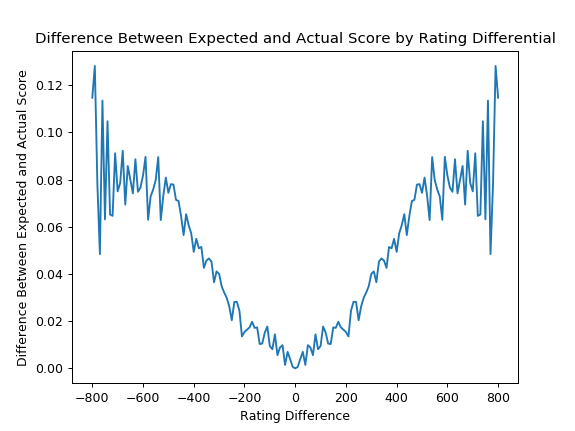

Text(0.5, 1.0, 'Difference Between Expected and Actual Score by Rating Differential')

In [19]:
plt.figure()
plt.plot(groupbinmeans.index.get_level_values(0), teststatistic, '-')
plt.xlabel('Rating Difference')
plt.ylabel('Difference Between Expected and Actual Score')
plt.title('Difference Between Expected and Actual Score by Rating Differential')

Plotting this shows that we are double counting the differences, so let us change this to be only values >= 0.

In [20]:
expectedscores2 = []
for RD in groupbinmeans.index.get_level_values(0):
    if RD <= 0:
        score = round(ratingdf.loc[ratingdf['RD'] >= RD, 'Score'].iloc[0], 2)
        expectedscores2.append(score)
        
scoresbyELOdiff2 = (1 - gbblackbinmeans.iloc[:81, 0] + groupbinmeans.iloc[:81, 0])/2
scoresbyELOdiff2

teststatistic2 = abs(scoresbyELOdiff2 - expectedscores2)
teststatistic2

bELOdiff10
-800    0.114733
-790    0.128187
-780    0.078233
-770    0.048458
-760    0.113504
          ...   
-40     0.001456
-30     0.006995
-20     0.003956
-10     0.000642
 0      0.000000
Name: Result, Length: 81, dtype: float64

<IPython.core.display.Javascript object>


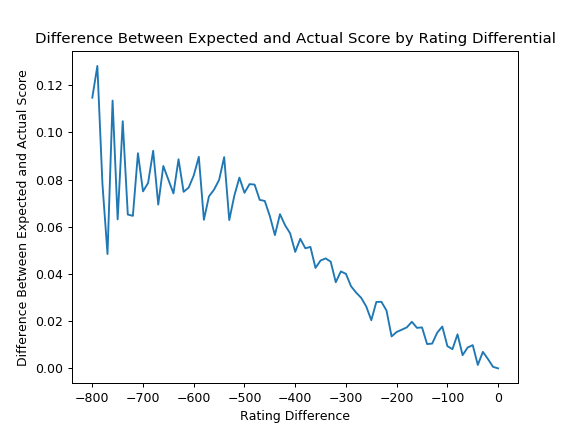

Text(0.5, 1.0, 'Difference Between Expected and Actual Score by Rating Differential')

In [21]:
plt.figure()
plt.plot(groupbinmeans.index.get_level_values(0)[:81], teststatistic2, '-')
plt.xlabel('Rating Difference')
plt.ylabel('Difference Between Expected and Actual Score')
plt.title('Difference Between Expected and Actual Score by Rating Differential')

In [22]:
#Calculating the test statistic mean, standard error, and estimated standard deviation.
xbar = np.mean(teststatistic2)
se = np.std(teststatistic2)
sd = se/np.sqrt(teststatistic2.count())
xbar, sd

(0.05040401404908205, 0.003497467896109494)

In [23]:
##Calculating Upper and Lower confidence intervals
upper = xbar + 1.96*sd
lower = xbar - 1.96*sd
upper,lower

(0.05725905112545666, 0.04354897697270744)

Because the confidence interval does not include 0, we reject the null hypothesis. We state that with 95% confidence, the scores observed were not due to random chance and that the observed score is significantly different from the FIDE expected score. There are the caveats that the data had some irregularities and the data does not generalize to all chess players, as the data was selected from a database that contained only master level games.